# Import Libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# time series
import time_series as ts # import custom functions

from sktime.utils.plotting import plot_series, plot_correlations

# set plots params
plt.style.use("fivethirtyeight") # change plot appearances

mpl.rcParams["figure.figsize"] = (12, 6) # set a figsize greater than default
mpl.rcParams["lines.linewidth"] = 2 # adjust line width
mpl.rc("font", family = "monospace", monospace = ["DejaVu Sans Mono"])
mpl.rc("axes", titlelocation = "left", titlepad = 12, titleweight = "bold")

# customisations as ref, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# https://matplotlib.org/stable/api/matplotlib_configuration_api.html#matplotlib.rcParams

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split, CutoffSplitter

daily_outflow = pd.read_csv("../data/bikemi_csv/daily_outflow.csv", parse_dates=[0], index_col=[0])
CutoffSplitter()


,count
giorno_partenza,
2019-01-01,831
2019-01-02,3512
2019-01-03,4126
2019-01-04,4201
2019-01-05,2875


# Time Series Analysis

## Univariate Time Series

Let's plot the data:

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='count'>)

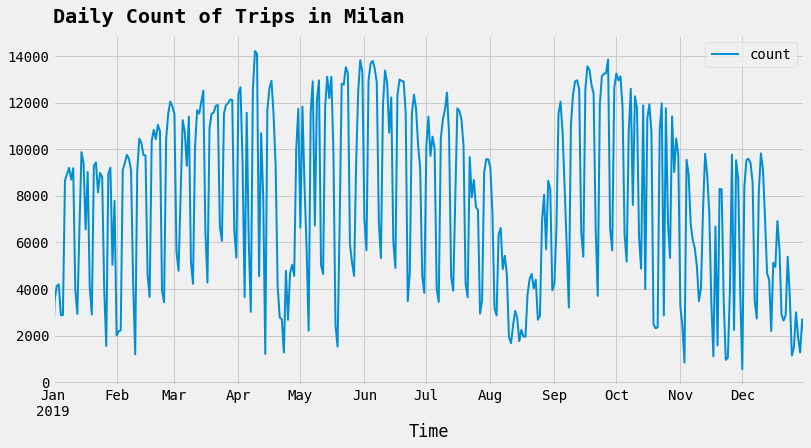

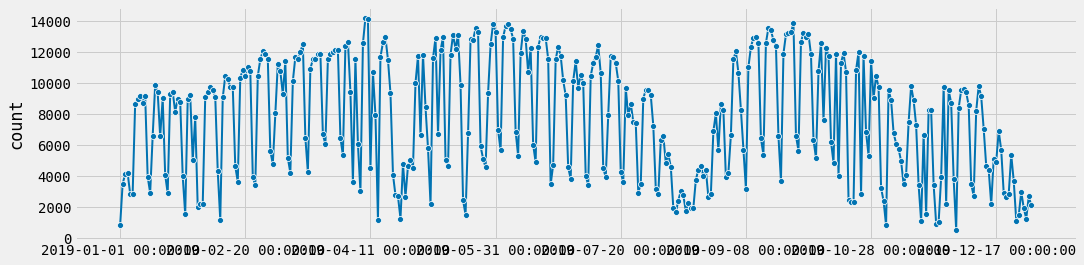

In [10]:
# we could also use plot_series, but default plotting is basically the same

daily_outflow.plot(
    y="count",
    title="Daily Count of Trips in Milan",
    xlabel="Time",
    ylabel=None
)

plot_series(daily_outflow["count"])

Given this distribution, we expect a strong relationship between data points that are seven lags from each other. More importantly, we expect that this variance will hinder the accuracy of our forecasts. This may require transforming the data (e.g. by taking logs or applying a Box-Cox transformation and searching for the optimal parameter $\lambda$) or *decomposing the time series*.

# Autocorrelation

Let's have a look at the autocorrelation function, before proceeding.

In [ ]:
ts.plot_acf_and_pacf(daily_outflow["count"])

Both plots show that the data is (unsurprisingly) non stationary. Besides, the ACF plot shows two components of the time-series:

* a trend, as the autocorrelation is declining;
* a (strong) seasonal component on the seventh lag - i.e., a strong weekly dependence.

Apart from the seasonal dependencies, the autorrelation quickly becomes undistinguisheable from zero.

Let's perform a Dickey Fuller test.

# Advanced Dickey Fuller Test

In [ ]:
ts.perform_adfuller(daily_outflow["count"])

The test statistic is greater than any critical value: in other words, we cannot reject the null hypothesis and the series is indeed non-stationary.

# Time-Series Decomposition

There are several alternatives:

* Apply a transformation (e.g., take logs);
* Subtract the rolling average (it can work here, since the frequency is clear. It becomes more complex in case of high-frequency data: which window shall be selected?)

In [ ]:
ts.seasonal_decompose(daily_outflow, model = "additive").plot();


As explained in the [official documentation](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html?highlight=seasonal%20decomposition),

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima [3].

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper-parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

Note that due to stationarity issues, auto-ARIMA might not find a suitable model that will converge. If this is the case, a ValueError will be thrown suggesting stationarity-inducing measures be taken prior to re-fitting or that a new range of order values be selected. Non- stepwise (i.e., essentially a grid search) selection can be slow, especially for seasonal data. Stepwise algorithm is outlined in Hyndman and Khandakar (2008).